In [1]:
import pandas as pd 

In [10]:
df=pd.read_csv('/content/sample_data/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [11]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [12]:
df.columns=['Production']

In [13]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


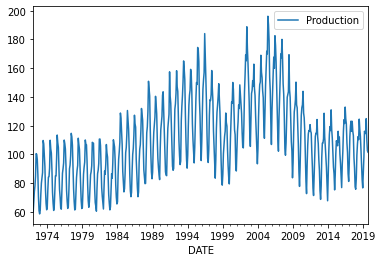

In [14]:
df.plot()

In [15]:
len(df)

573

In [16]:
test_size=24
test_ind=len(df)-test_size
train=df.iloc[:test_ind]
test=df.iloc[test_ind:]

In [17]:
print(len(train))
len(test)

549


24

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [19]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [20]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length=18
n_features=1
train_generator=TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)
test_generator=TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=1)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM


In [51]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [53]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=4)

In [54]:
model.fit_generator(train_generator,epochs=20,validation_data=test_generator,callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
531/531 [==============================] - 5s 8ms/step - loss: 0.0258 - val_loss: 0.0033
Epoch 2/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 3/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 4/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 5/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 6/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 8/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 9/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0030 - val_loss: 0.0060
Epoch 10/20
531/531 [==============================] - 4s 8ms/step - loss: 0.0029 - val_loss: 0.0026

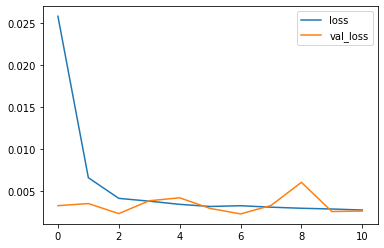

In [55]:
loss=pd.DataFrame(model.history.history)
loss.plot()

In [56]:
import numpy as np

test_predictions=[]

first_eval_batch=scaled_train[-length:]
print(first_eval_batch.shape)
current_batch=first_eval_batch.reshape((1,length,n_features))

for i in range(len(test)):
  pred=model.predict(current_batch)[0]
  test_predictions.append(pred)
  current_batch=np.append(current_batch[:,1:,:],[[pred]],axis=1)

(18, 1)


In [57]:
true_predictions=scaler.inverse_transform(test_predictions)

In [58]:
test['predictions']=true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
test

,Production,predictions
DATE,,
2017-10-01,90.4732,87.723108
2017-11-01,77.4378,81.017992
2017-12-01,75.8118,82.866822
2018-01-01,83.4343,93.574779
2018-02-01,99.4899,103.792929
2018-03-01,107.3152,111.919636
2018-04-01,112.4309,117.492086
2018-05-01,110.3544,119.897549
2018-06-01,124.5841,117.030884


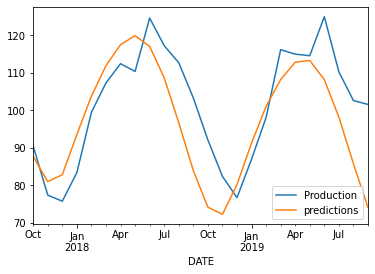

In [60]:
test.plot()

In [62]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test['Production'],test['predictions']))

11.33577170060406